<a href="https://colab.research.google.com/github/ipanditi/ML/blob/main/Karpathy0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
pip install micrograd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
from micrograd.engine import Value

In [60]:
 import math 
 import numpy as np
 import matplotlib.pyplot as plt
 %matplotlib inline

In [61]:
def f(x):
  return 3*x**2 - 4*x + 5

In [62]:
f(3.0)

20.0

In [63]:
xs = np.arange(-5,5,0.25) # Gives an array with range -5 to +5 with step as 0.25
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

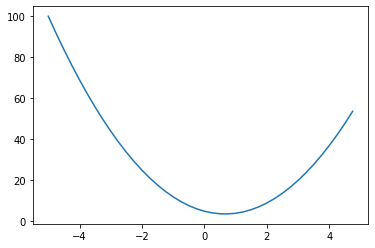

In [64]:
plt.plot(xs,ys)

In [65]:
#Lets find the derivative
h = 0.001
x = 3.0
f(x+h)

20.014003000000002

In [66]:
(f(x+h)-f(x))/h

14.00300000000243

In [67]:
#Lets complicate the things a bit
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [68]:
h = 0.0001

#imputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
a+=h
d2 = a*b+c
print('d1', d1) #Actual change
print('d2', d2) #Normalized change using h
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


as we can see derivative of d w.r.t a will give us b which is 3 and that is the slope we got in the result

In [69]:
#Now w.r.t b
d1 = a*b+c
b+=h
d2 = a*b+c
print('d1', d1) #Actual change
print('d2', d2) #Normalized change using h
print('slope', (d2-d1)/h)


#Now w.r.t c
d1 = a*b+c
c+=h
d2 = a*b+c
print('d1', d1) #Actual change
print('d2', d2) #Normalized change using h
print('slope', (d2-d1)/h)

d1 3.999699999999999
d2 3.99990001
slope 2.0001000000124947
d1 3.99990001
d2 4.00000001
slope 0.9999999999976694


Here as we differentiate w.r.t b we get a which is 2;
Similarly when we differentiate w.r.t c we get 1

In [157]:
class Value:
  """ stores a single scalar value and its gradient """
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None #For leaf node there is nothing to do in the backprop
    self._prev = set(_children)
    self._op = _op
    self.label = label
  
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other),'+')
    def _backward():
      self.grad += 1.0*out.grad
      other.grad += 1.0*out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other),'*')
    def _backward():
      self.grad += other.data* out.grad
      other.grad += self.data*out.grad
    out._backward = _backward
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    n = self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1- t**2)*out.grad
    out._backward = _backward
    return out

  def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLu')

    def _backward():
      self.grad += (out.data>0) * out.grad
    out._backward = _backward
      
  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    #Reverse topological sorting
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

  def __neg__(self): # -self
        return self * -1

  def __radd__(self, other): # other + self
        return self + other

  def __sub__(self, other): # self - other
        return self + (-other)

  def __rsub__(self, other): # other - self
        return other + (-self)

  def __rmul__(self, other): # other * self
        return self * other

  def __truediv__(self, other): # self / other
        return self * other**-1

  def __rtruediv__(self, other): # other / self
        return other * self**-1

  def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"


#Crete an object of class Value and manipulate it
a=Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label = 'c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0, grad=0.0)

In [115]:
L._prev  #Give the individual term values

{Value(data=-2.0, grad=0.0), Value(data=4.0, grad=0.0)}

In [116]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'ramkdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label="{%s | data %.4f | grad %.4f }"%(n.label, n.data, n.grad ), shape='record')
    if n._op:
      dot.node(name=uid + n._op, label=n._op)
      dot.edge(uid+ n._op, uid)
  for n1,n2 in edges:
    dot.edge(str(id(n1)), str(id(n2))+ n2._op)
  return dot

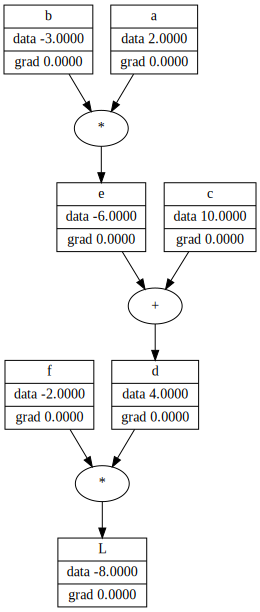

In [117]:
draw_dot(L)

In [118]:
'''L.grad= 1.0
d.grad = f.data
f.grad = d.data
c.grad = -2.0
e.grad = -2.0
a.grad = (-2.0 * -3.0)
b.grad = (-2.0* 2.0)'''

'L.grad= 1.0\nd.grad = f.data\nf.grad = d.data\nc.grad = -2.0\ne.grad = -2.0\na.grad = (-2.0 * -3.0)\nb.grad = (-2.0* 2.0)'

In [119]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-8.0


In [120]:
#Manual backpropagation
def lol():
  h=0.001

  a=Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label='e'
  d = e+c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data

  a=Value(2.0, label='a')
  #a.data+=h
  b = Value(-3.0, label='b')
  b.data+=h
  c = Value(10.0, label = 'c')
  #c.data +=h
  e = a*b; e.label='e'
  #e.data +=h
  d = e+c; d.label='d'
  #d.data += h
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
lol()

-3.9999999999995595


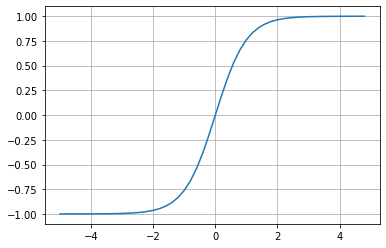

In [121]:
'''Backpropagate through a neuron'''
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

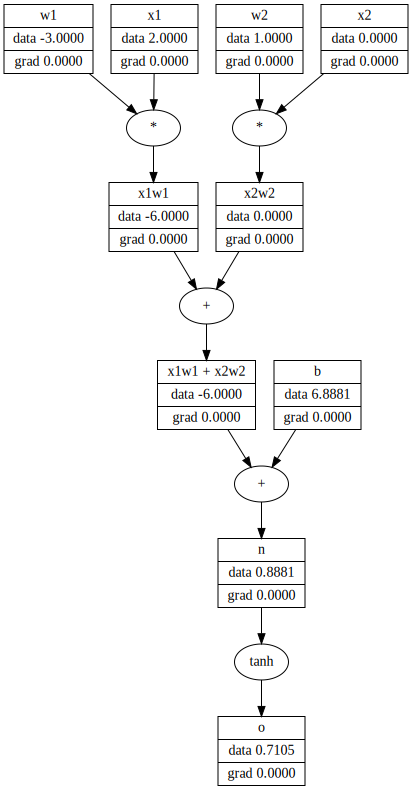

In [122]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#Bias
b = Value(6.88813, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [123]:
'''
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
'''

'\no.grad = 1.0\nn.grad = 0.5\nx1w1x2w2.grad = 0.5\nb.grad = 0.5\nx1w1.grad = 0.5\nx2w2.grad = 0.5\nx2.grad = w2.data * x2w2.grad\nw2.grad = x2.data * x2w2.grad\nx1.grad = w1.data * x1w1.grad\nw1.grad = x1.data * x1w1.grad\n'

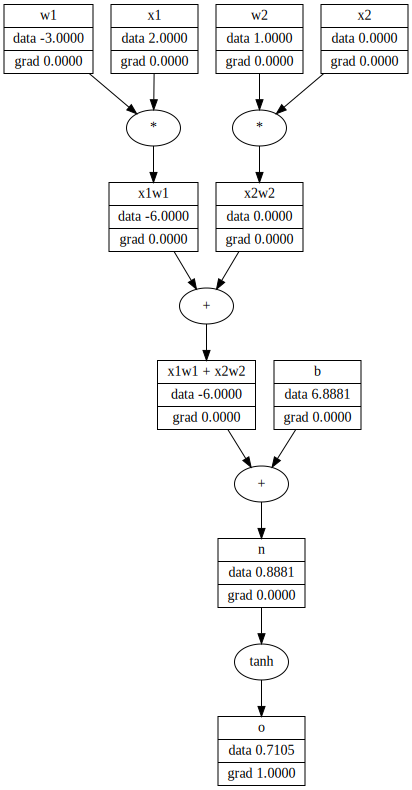

In [124]:
o.grad = 1.0
draw_dot(o)

In [125]:
o._backward()

In [126]:
n._backward()

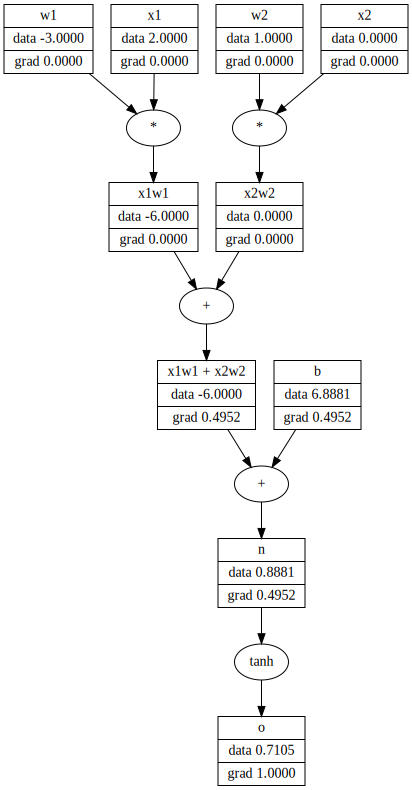

In [127]:
draw_dot(o)

In [128]:
x1w1x2w2._backward()

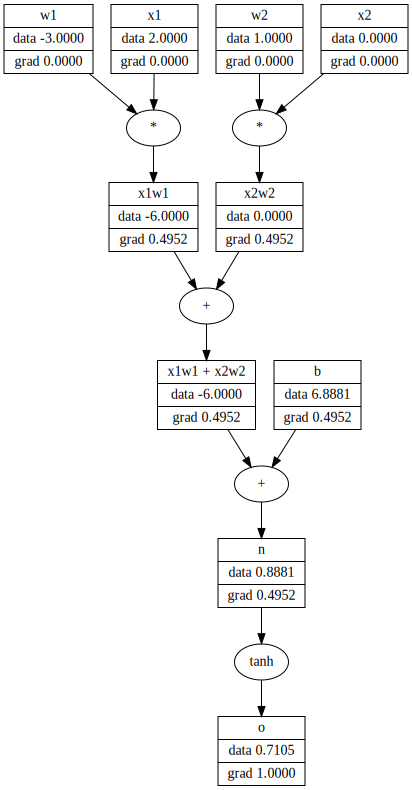

In [129]:
draw_dot(o)

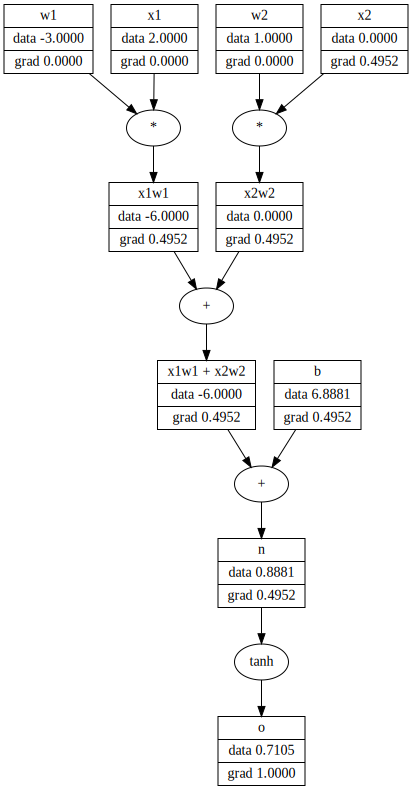

In [130]:
x2w2._backward()
draw_dot(o)

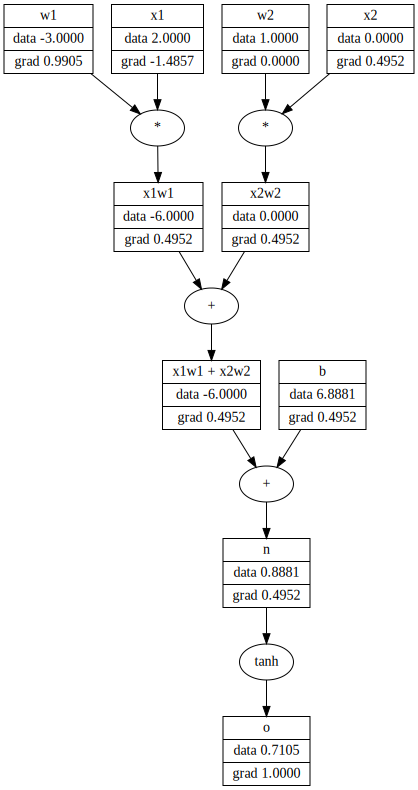

In [131]:
x1w1._backward()
draw_dot(o)

**OK but this was iterative, how do we generalize the process of backpropagation and do it in a single step for the whole DAG, HAHAHAHAHA you are right topological sorting!!!**

In [132]:
#TOPOLOGICAL SORTING
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.88813, grad=0.49523397893379417),
 Value(data=0.0, grad=0.49523397893379417),
 Value(data=1.0, grad=0.0),
 Value(data=0.0, grad=0.49523397893379417),
 Value(data=2.0, grad=-1.4857019368013824),
 Value(data=-3.0, grad=0.9904679578675883),
 Value(data=-6.0, grad=0.49523397893379417),
 Value(data=-6.0, grad=0.49523397893379417),
 Value(data=0.8881300000000003, grad=0.49523397893379417),
 Value(data=0.7104688741009038, grad=1.0)]

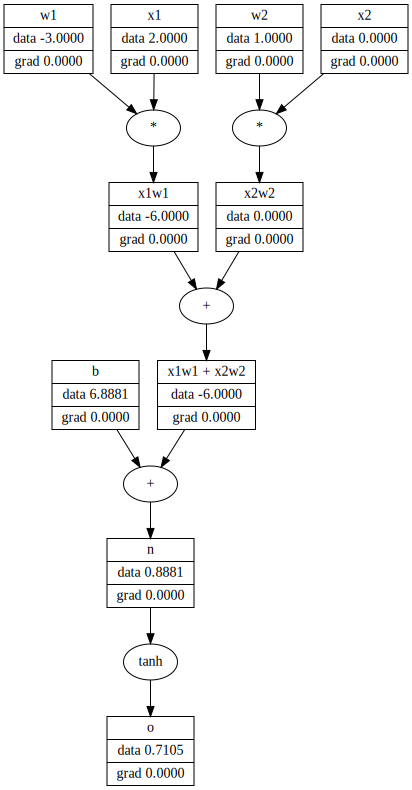

In [133]:
#Reset the grads to 0
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#Bias
b = Value(6.88813, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [134]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

#Reverse topological sorting
for node in reversed(topo):
  node._backward()

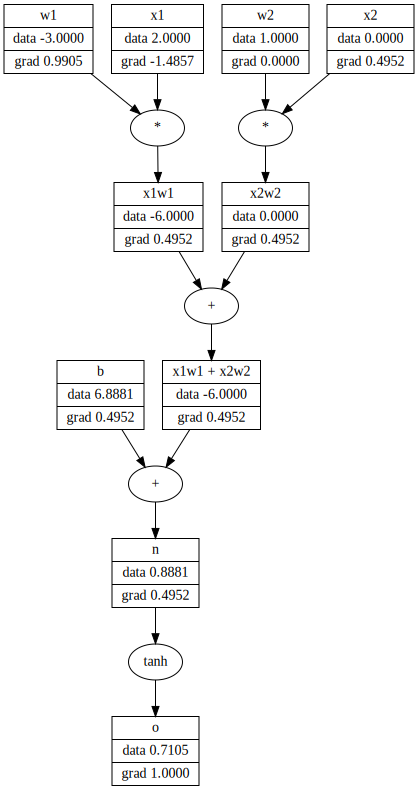

In [135]:
draw_dot(o)

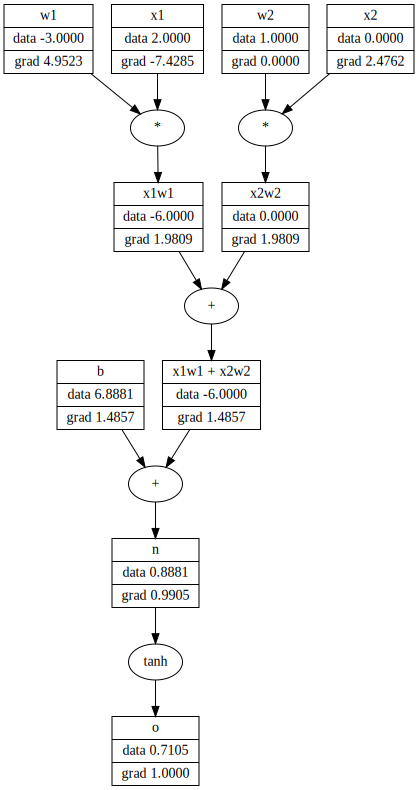

In [136]:
#Do it one go!
o.backward()
draw_dot(o)

In [137]:
'''import torch
x1 = torch.Tensor([2.0]).double()         ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()         ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()        ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()         ;w2.requires_grad = True
b = torch.Tensor([6.88137358]).double()   ;b.requires_grad = True
n = x1*w1 + x2*w2 + b     
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', x2.grad.item())
print('x1', x2.grad.item())
print('w1', x2.grad.item())'''

"import torch\nx1 = torch.Tensor([2.0]).double()         ;x1.requires_grad = True\nx2 = torch.Tensor([0.0]).double()         ;x2.requires_grad = True\nw1 = torch.Tensor([-3.0]).double()        ;w1.requires_grad = True\nw2 = torch.Tensor([1.0]).double()         ;w2.requires_grad = True\nb = torch.Tensor([6.88137358]).double()   ;b.requires_grad = True\nn = x1*w1 + x2*w2 + b     \no = torch.tanh(n)\n\nprint(o.data.item())\no.backward()\n\nprint('---')\nprint('x2', x2.grad.item())\nprint('w2', x2.grad.item())\nprint('x1', x2.grad.item())\nprint('w1', x2.grad.item())"

In [138]:
import random
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [139]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.14766301523631103, grad=0.0)

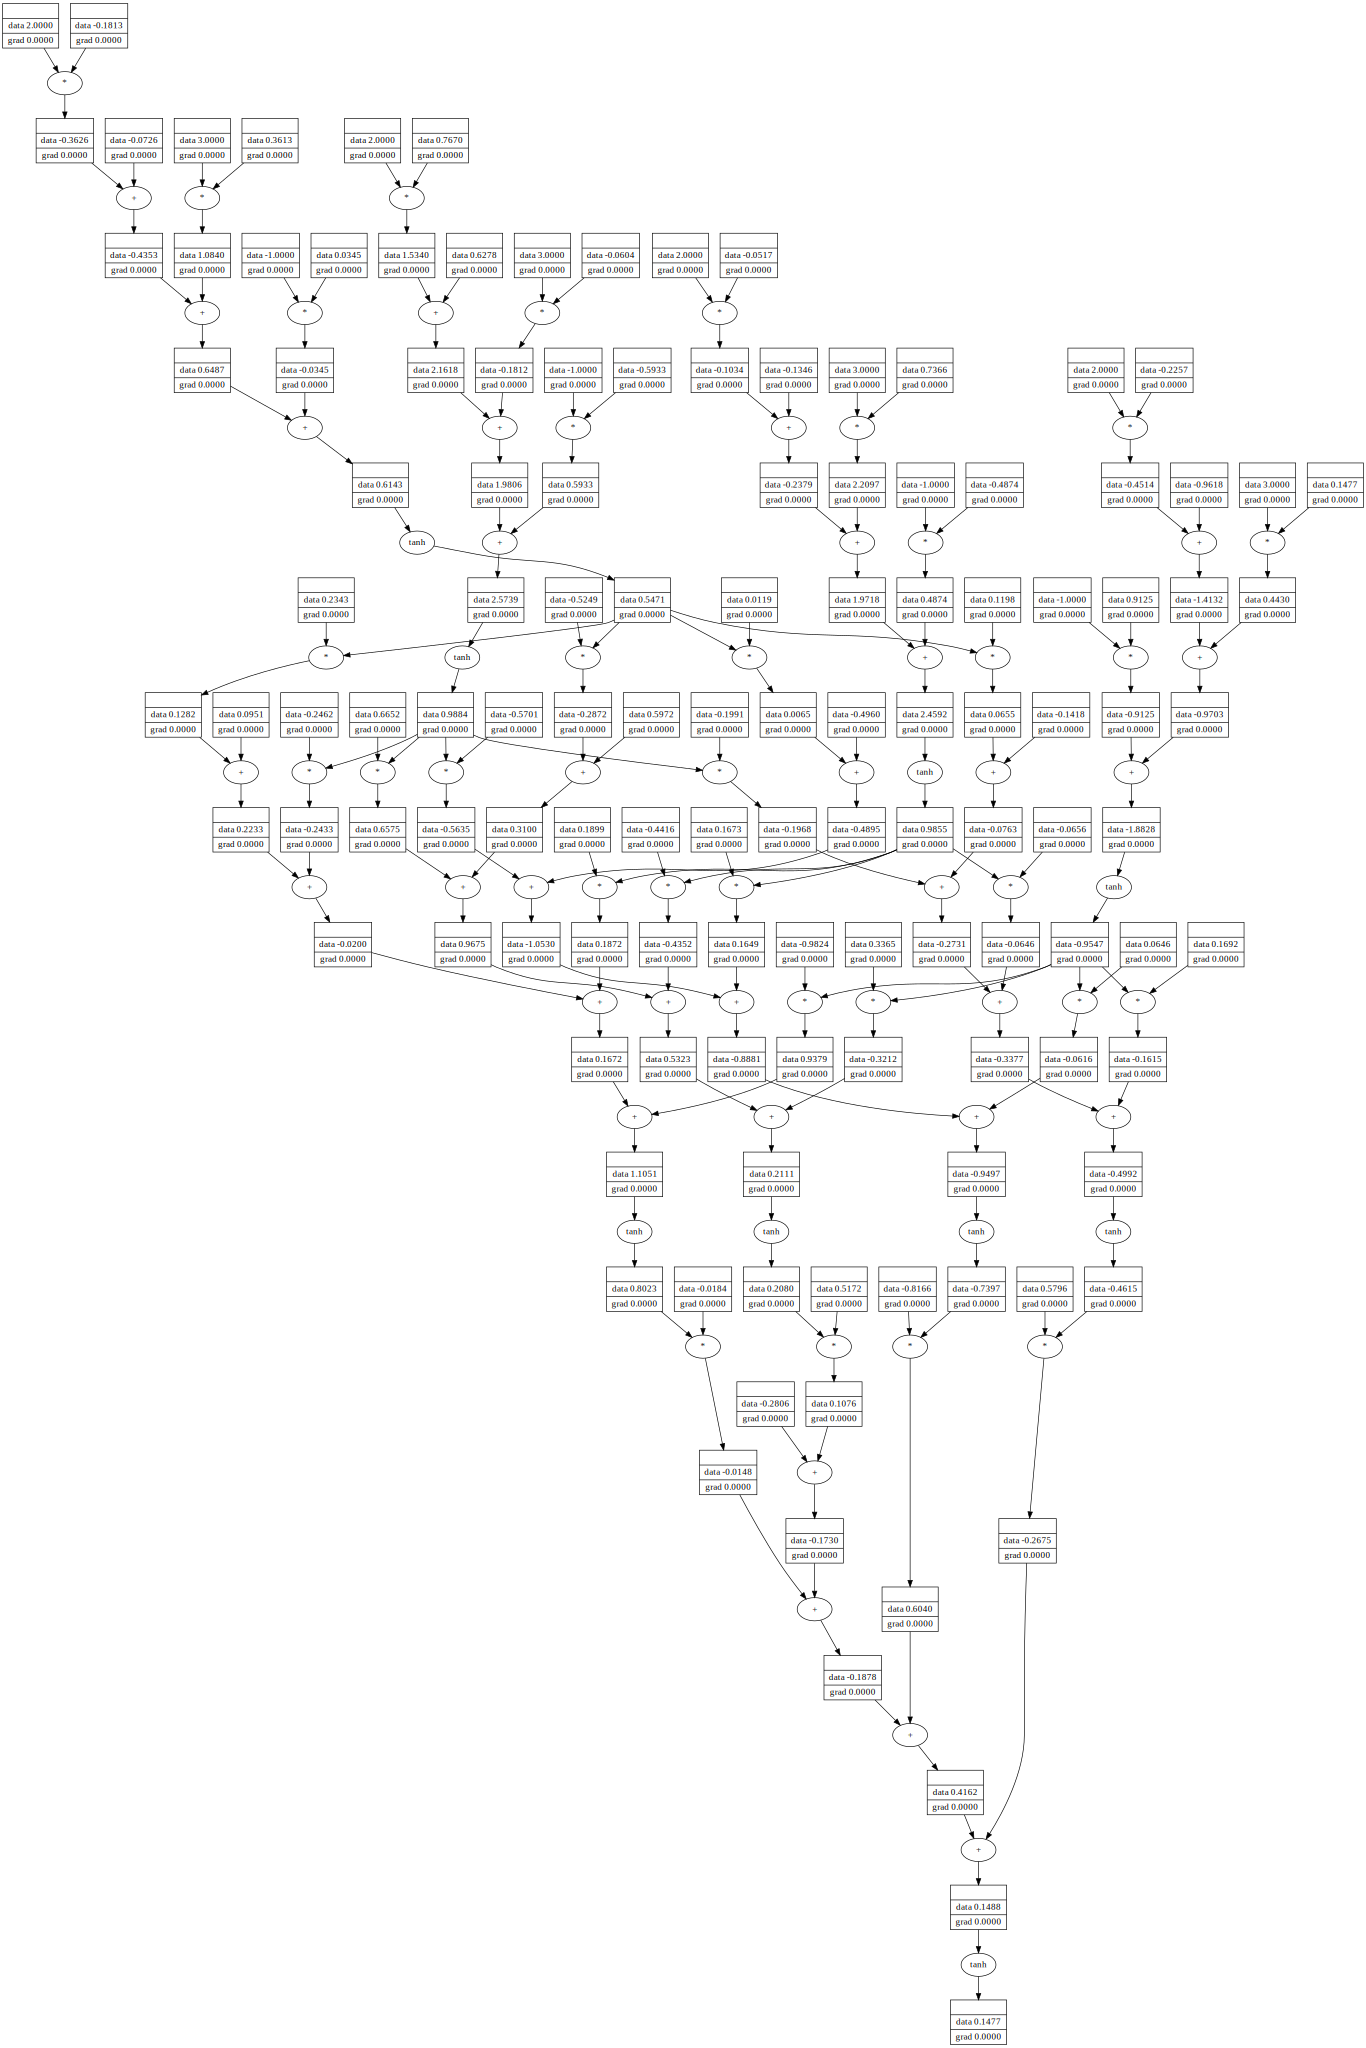

In [140]:
draw_dot(n(x))

In [141]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.14766301523631103, grad=0.0),
 Value(data=0.5504765464252018, grad=0.0),
 Value(data=0.36989440502769866, grad=0.0),
 Value(data=0.27744918400804364, grad=0.0)]

In [143]:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))
loss

Value(data=5.5291462192275125, grad=0.0)

In [144]:
loss.backward()

In [145]:
n.layers[0].neurons[0].w[0].grad

0.6115550022265759

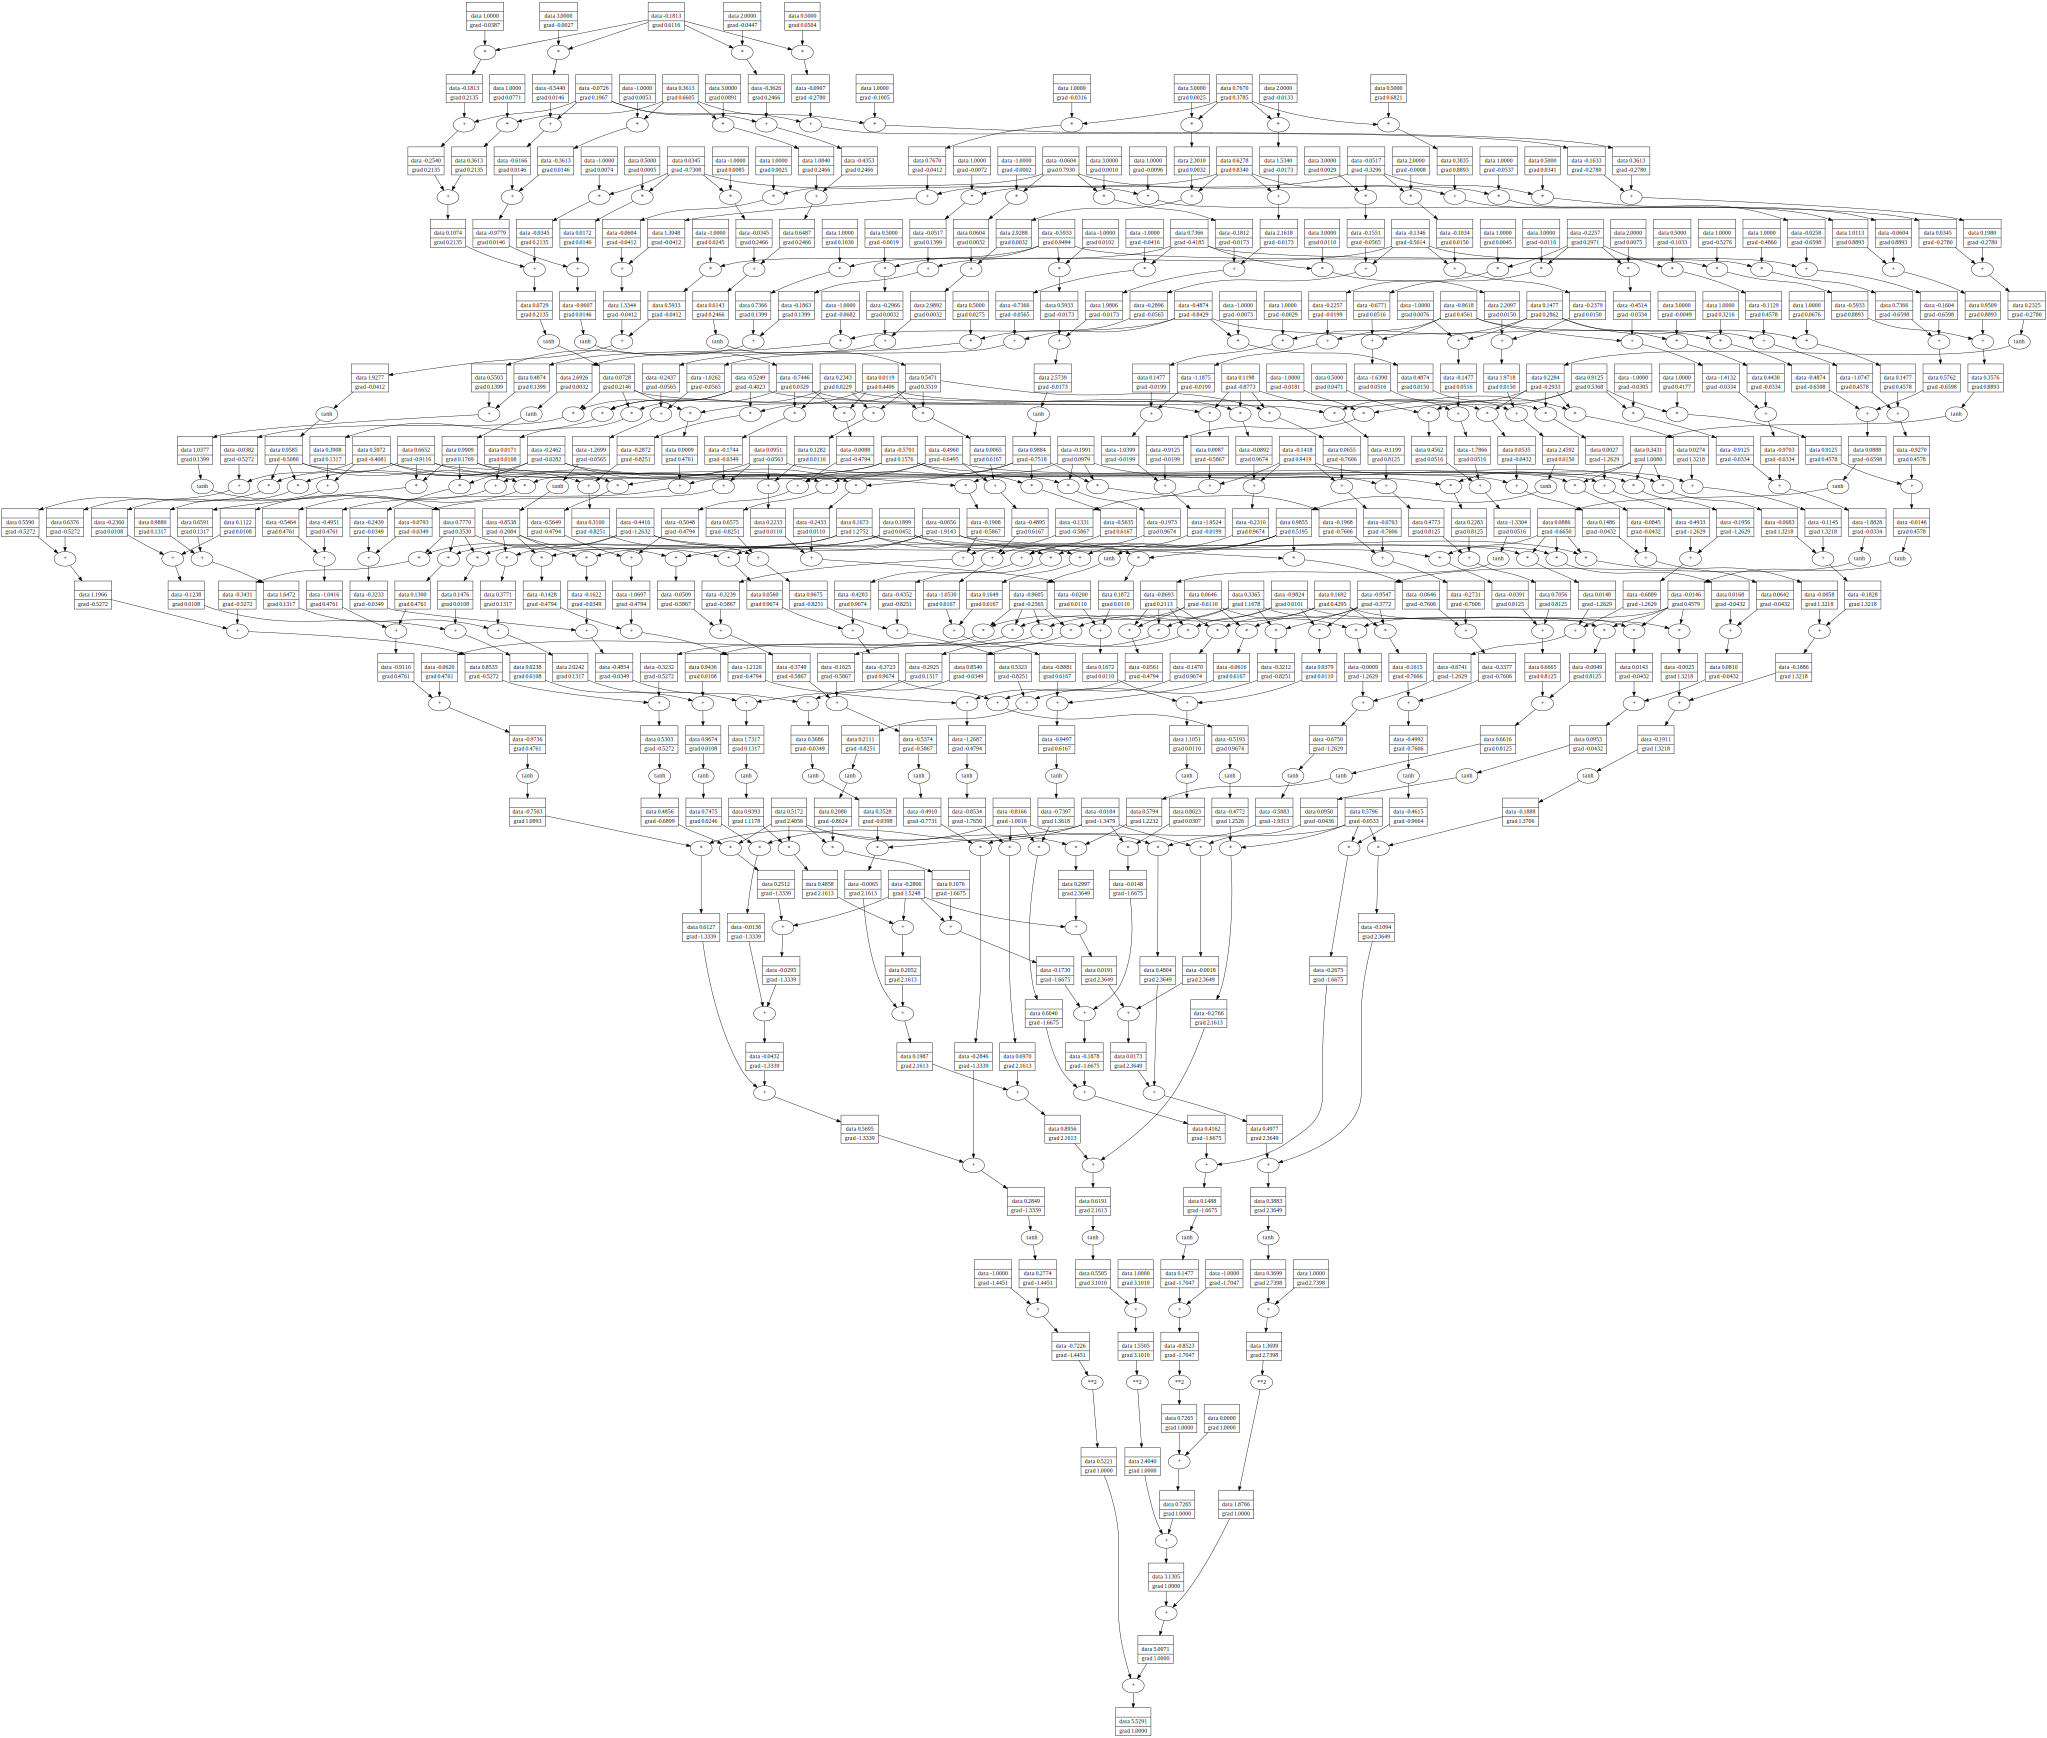

In [146]:
draw_dot(loss)

In [149]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # stochastic gradient update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 5.245098289564359
1 3.2909355896227286
2 2.325365869112998
3 1.4603182752486379
4 1.0779363308571634
5 0.28943442067913566
6 0.08392613367874022
7 0.06624843798930775
8 0.054791599719192896
9 0.046594720938591294
10 0.04042126183162874
11 0.03560942511985693
12 0.031760789935284424
13 0.028618432442124437
14 0.02600869560022492
15 0.023809948024799264
16 0.02193452211679353
17 0.020317701306638764
18 0.018910725307724544
19 0.017676197911489926


In [150]:
ypred

[Value(data=0.9434090958953468, grad=-0.11318180820930634),
 Value(data=-0.9299939779025558, grad=0.14001204419488844),
 Value(data=-0.9479452905364973, grad=0.10410941892700531),
 Value(data=0.9171559804399234, grad=-0.16568803912015317)]

ys = [1.0, -1.0, -1.0, 1.0] are the desired targets whereas we have predicted [0.94, -0.93, -0.95, 0.91] which seems pretty accurate 

**BINARY CLASSIFIER DEMO**

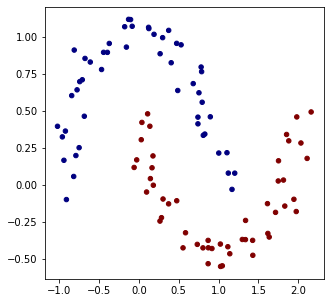

In [154]:
np.random.seed(1337)
random.seed(1337)
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [155]:
model = MLP(2, [16, 16, 1]) #2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


In [170]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


In [171]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

TypeError: ignored

(-1.548639298268643, 1.951360701731357)

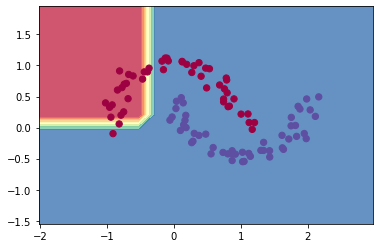

In [167]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())